In [1]:
import pandas as pd 
import numpy as np
from tqdm import tqdm
from scipy.stats import zscore, spearmanr, rankdata
from statsmodels.formula.api import ols
import math

from matplotlib import pyplot as plt
%matplotlib inline
plt.rcParams['figure.figsize'] = [9, 5]

import os
import sys
sys.path.append('../')
from alpha_191 import Alpha191

import warnings
warnings.filterwarnings('ignore')

import feather

### 读取自存数据

In [ ]:
universe = feather.read_dataframe('bitcoin_data/raw36_20220301_now.feather')
universe = universe.drop(columns=['close time'])
#universe['date'] = pd.to_datetime(universe['date'],format='%Y-%m-%d %H:%M:%S')
universe = universe.set_index(['date']).sort_values(by=['date', 'ts_code'])

In [ ]:
#universe.loc[universe.ts_code=='BTCUSDT'].head(10)
universe = universe.loc[universe.index >= '2022-06-01 00:00:00']

In [ ]:
universe['vwap'] = universe['amount']/universe['volume']
universe = universe.rename(columns={'open':'open_usdt', 'high':'high_usdt', 'low':'low_usdt', 
                                    'close':'close_usdt', 'vwap':'vwap_usdt'})

In [ ]:
def my_groupby(df, column, func, sort_keys=['date', 'ts_code']):
    all_df = pd.DataFrame()
    for val in tqdm(df[column].unique()):
        tmp = df.loc[df[column] == val]
        all_df = all_df.append(func(tmp))
    return all_df.sort_index(level=sort_keys)

In [ ]:
def convert_price_to_returns(df):
    def cal_(data):
        data['close'] = data['close_usdt'].pct_change()
        data['close'] = (data['close'].fillna(0) + 1).cumprod()
        data['vwap'] = data['vwap_usdt'].pct_change()
        data['vwap'] = (data['vwap'].fillna(0) + 1).cumprod()
        
        for feature in ['open', 'high', 'low',]:
            data[feature] = data[feature + '_usdt']/data['close_usdt'] * data['close']
        return data
    
    df = my_groupby(df, 'ts_code', cal_)
    return df

universe = convert_price_to_returns(universe)

In [ ]:
universe['trade_date'] = universe.index
universe = universe.loc[universe.ts_code!='TUSDUSDT'].sort_values(by=['date', 'ts_code'])

In [ ]:
# tmp = universe.loc[(universe.ts_code=='BTCUSDT') & (universe.index>'2023-05-25 00:00:00')]
# tmp[['close']] = tmp[['close']].apply(zscore)
# #universe
# tmp[['ppo', 'ppos', 'close']].plot(grid=True)
universe.ts_code.unique()

### 构造技术指标为alpha

In [ ]:
import stockstats

class IndicatorHelper(pd.DataFrame):
    """
        add indicators to dataframe
    """

    def __init__(self, data):
        super(IndicatorHelper, self).__init__(data)

        self.stocks = stockstats.StockDataFrame.retype(data.copy())
        self.df = self

    def add_technical_indicator(self, tech_indicator_list):
        """
        calculate technical indicators
        use stockstats package to add technical inidactors
        :param ticker: (df) pandas dataframe
        :param tech_indeicator_list list
        :return: (df) pandas dataframe
        """
        unique_ticker = self.df.ts_code.unique()

        indicator_df = pd.DataFrame()
        for i in tqdm(range(len(unique_ticker)), desc='add tech indicators'):
            temp_indicator = self.stocks[self.stocks.ts_code == unique_ticker[i]]
            temp_indicator = temp_indicator[tech_indicator_list + ['ts_code', 'trade_date']]
            indicator_df = indicator_df.append(temp_indicator, ignore_index=True)
        
        self.df = self.df.merge(indicator_df, on=["ts_code", "trade_date"], how="left")
        self.df['date'] = self.df['trade_date'].apply(lambda x: pd.Timestamp(x))
        self.df = self.df.set_index(['date']).sort_values(
                    by=['date', 'ts_code']).drop_duplicates(subset=['trade_date','ts_code'])
        return self.df
    

In [ ]:
# add tech indicators
tech_indicator_list = ['log-ret','wt1', 'wt2','stochrsi_6', 'cci', 'cci_6', 'rsi_6', 'wr_6', 'close_10_kama_5_30',
                       'ppo', 'ppos', 'macds', 'macd', 'macdh', 'kdjj', 'kdjk', 'kdjd', 'atr', 'atr_6', 'supertrend'] 
universe = IndicatorHelper(universe).add_technical_indicator(tech_indicator_list)

### 构造指数

In [ ]:
index_df = pd.DataFrame(index=universe.index.unique())
index_df['close'] = 0.65 * universe.loc[universe.ts_code == 'BTCUSDT']['close'] \
                    + 0.35 * universe.loc[universe.ts_code == 'ETHUSDT']['close']
index_df['open'] = 0.65 * universe.loc[universe.ts_code == 'BTCUSDT']['open'] \
                    + 0.35 * universe.loc[universe.ts_code == 'ETHUSDT']['open']
index_df['high'] = 0.65 * universe.loc[universe.ts_code == 'BTCUSDT']['high'] \
                    + 0.35 * universe.loc[universe.ts_code == 'ETHUSDT']['high']
index_df['low'] = 0.65 * universe.loc[universe.ts_code == 'BTCUSDT']['low'] \
                    + 0.35 * universe.loc[universe.ts_code == 'ETHUSDT']['low']
index_df['log-ret'] = 0.65 * universe.loc[universe.ts_code == 'BTCUSDT']['log-ret'] \
                    + 0.35 * universe.loc[universe.ts_code == 'ETHUSDT']['log-ret']
index_df.head()

In [ ]:
def base_indicators(df):
    def cal_(data):
        data['range_5'] = data['high'].rolling(5).max() - data['low'].rolling(5).min()
        data['wave_5'] = data['close'].rolling(5).std()
        data['range_10'] = data['high'].rolling(10).max() - data['low'].rolling(10).min()
        data['wave_10'] = data['close'].rolling(10).std()
        data['range_14'] = data['high'].rolling(14).max() - data['low'].rolling(14).min()
        data['wave_14'] = data['close'].rolling(14).std()
        data['ret_5'] = data['log-ret'].rolling(5).sum()
        data['ret_10'] = data['log-ret'].rolling(10).sum()
        data['buy_percent5'] = (data['buy_amount']/data['amount']).rolling(5).mean()
        data['buy_percent10'] = (data['buy_amount']/data['amount']).rolling(10).mean()
        return data
    
    df = my_groupby(df, 'ts_code', cal_)
    return df

universe = base_indicators(universe)

In [3]:
def Corr(data, win_len):
    obj = data.rolling(window=win_len, method='table')
    s = []
    for o in obj:
        if o.shape[0] < win_len:
            s.append(0.)
        else:
            s.append(spearmanr(o.iloc[:, 0], o.iloc[:, 1])[0])
            # s.append(o.iloc[:, 0].corr(o.iloc[:, 1]))
    return pd.DataFrame(s, index=data.index, columns=['corr'])

def ts_rank(data, window=10):
    return data.rolling(window).apply(lambda x: rankdata(x)[-1])

def Highday(sr, window):
    return sr.rolling(window).apply(lambda x: len(x) - x.values.argmax())

def Lowday(sr, window):
    return sr.rolling(window).apply(lambda x: len(x) - x.values.argmin())

def Regbeta(sr, x):
    window = len(x)
    return sr.rolling(window).apply(lambda y: np.polyfit(x, y, deg=1)[0])

def Sequence(n):
    return np.arange(1, n + 1)

def Decaylinear(sr, window):
    weights = np.array(range(1, window + 1))
    sum_weights = np.sum(weights)
    return sr.rolling(window).apply(lambda x: np.sum(weights * x) / sum_weights)

def rolling_jump(sr, win, interval):
    
    if win>=interval:
        result = [np.nan]*(win-interval)
        for i in range(win, len(sr), interval):
            result.extend([np.nan]*(interval-1) + [sr[i-win:i].mean()])
    else:
        result = []
        for i in range(interval, len(sr), interval):
            result.extend([np.nan]*(interval-1) + [sr[i-win:i].mean()])
            
    if len(sr) > len(result):
        result.extend([np.nan]*(len(sr) - len(result)))
    return pd.Series(result, sr.index)

def my_groupby(df, column, func, sort_keys=['date', 'ts_code']):
    all_df = pd.DataFrame()
    for val in tqdm(df[column].unique()):
        tmp = df.loc[df[column] == val]
        all_df = all_df.append(func(tmp))
    return all_df.sort_values(by=sort_keys)

### 构造alpha因子

In [ ]:
universe['alpha_wt'] = -(universe['wt1'] - universe['wt2'])
universe['alpha_cci'] = -universe['cci']
universe['alpha_cci1'] = -universe['cci_6']
universe['alpha_srsi'] = -universe['stochrsi_6']
universe['alpha_rsi'] = -universe['rsi_6']
universe['alpha_wr'] = -universe['wr_6']
universe['alpha_ppo'] = (universe['ppos'] - universe['ppo'])
universe['alpha_ppo1'] = -universe['ppos']
universe['alpha_macd'] = (universe['macds'] - universe['macd'])
universe['alpha_kdj'] = -((universe['kdjj'] - universe['kdjk'])
                           + (universe['kdjk'] - universe['kdjd']))
universe['alpha_atr'] = -universe['atr']
universe['alpha_atr1'] = -universe['atr_6']
universe['alpha_supertrend'] = universe['supertrend'] - universe['close']
universe['alpha_supertrend1'] = universe['close'].rolling(5).mean() - universe['supertrend']
universe['alpha_kama1'] = -universe['close_10_kama_5_30']

In [ ]:
def alpha_kama(df):
    feature = 'close_10_kama_5_30'
    def cal_(df):
        kama_filter = df[feature].rolling(20).std()
        cond_in1 = (df[feature] - df[feature].shift(1)) >kama_filter
        cond_in2 = (df[feature].shift(1) - df[feature].shift(2)) > kama_filter
        cond_out1 = (df[feature] - df[feature].shift(1)) < -kama_filter
        cond_out2 = (df[feature].shift(1) - df[feature].shift(2)) < -kama_filter
        df['alpha_kama'] = np.where((cond_out1 & cond_out2), -1 , np.nan)
        df['alpha_kama'] = np.where((cond_in1 & cond_in2), 1 , df['alpha_kama'])
        df['alpha_kama'] = df['alpha_kama'].fillna(method='ffill').fillna(0.) * kama_filter
        return df
    
    df = my_groupby(df, 'ts_code', cal_)
    return df

universe = alpha_kama(universe)

In [ ]:
def alpha_t1(df):
    def cal_(data):
        cond1 = data['macdh'] - data['macdh'].shift(1)
        cond2 = data['macdh'].shift(1) - data['macdh'].shift(2)
        val_pos = 10 - ts_rank(data['macdh'], 9)
        val_neg = 10 - ts_rank(-data['macdh'], 9)
        data['alpha_t1'] = np.where(((cond1>0) & (cond2>=0)), -1/val_pos,
                            np.where(((cond1<0) & (cond2<=0)), 1/val_neg, 0.))
        return data
    
    df = my_groupby(df, 'ts_code', cal_)
    return df

universe = alpha_t1(universe)

In [ ]:
def alpha_t2(df):
    def cal_(data):
        data['alpha_t2'] = np.where(data['ret_5']>0, 
                                    -data['ret_5'] * data['buy_percent5'],
                                    -data['ret_5'] * (1 - data['buy_percent5']))
        
        return data
    
    df = my_groupby(df, 'ts_code', cal_)
    return df

universe = alpha_t2(universe)

In [ ]:
def alpha_t4(df):
    def cal1_(sr, win_len=5):
        section = sr
        section = -np.where(section < section.shift(win_len),
                                   (section - section.shift(win_len)) / section.shift(win_len),
                                   np.where(section > section.shift(win_len),
                                            (section - section.shift(win_len)) / section, 0.))
        return pd.Series(section, index=sr.index)

    ## 4 hour
    def cal2_(data):
        section1 = cal1_(data['close'], 5)
        section2 = rolling_jump(section1, 4, 3).fillna(method='ffill')
        
        data['alpha_t4'] = np.where((section1>0)&(section2>0), section1,
                                    np.where((section1<0)&(section2<0), section1, section2))
        data['alpha_t4a'] = cal1_(data['close'], 5)
        return data
    
    df = my_groupby(df, 'ts_code', cal2_)
    return df

universe = alpha_t4(universe)

In [ ]:
def alpha_t5(df):
    def cal_(data):
        data['alpha_t5'] = -(data['close'] - data['low'].rolling(5).min())/data['wave_10']
        
        high_4h = rolling_jump(data['high'].rolling(4).max(), 1, 4).fillna(method='ffill')
        low_4h = rolling_jump(data['low'].rolling(4).min(), 1, 4).fillna(method='ffill')
        data['alpha_t5a'] = -np.sign(data['ret_5']) * (high_4h - low_4h) / \
                                ts_rank(data['volume'].rolling(4).mean(), 12)
        data['alpha_t5a'] = np.where(data['alpha_t5a']>0, data['alpha_t5a']/(data['buy_percent5']+1),
                                    data['alpha_t5a']/(2 - data['buy_percent5']))
        
        return data
    
    df = my_groupby(df, 'ts_code', cal_)
    return df

universe = alpha_t5(universe)

In [78]:
def alpha_t6(df):
    def cal_(data):
        atr_rolling = data['atr'].rolling(120)
        up_line = atr_rolling.mean() + 1.2*atr_rolling.std()
        down_line = atr_rolling.mean() - 1.2*atr_rolling.std()
        jud = data['atr'] - data['atr'].shift(1)
        data['alpha_t6'] = np.where((data['atr']>=up_line), -data['atr'],
                                   np.where((data['atr']<=down_line), data['atr'], 0))
        data['alpha_t6'] = data['alpha_t6'].rolling(5).mean()
        return data
    
    df = my_groupby(df, 'ts_code', cal_)
    return df

universe = alpha_t6(universe)

100%|███████████████████████████████████████████| 35/35 [00:03<00:00,  9.36it/s]


In [ ]:
def alpha_t7(df):
    def cal_(data):
        jud = data['cci'] - data['cci'].shift(1)
        other = (data['alpha_rsi'] + 50) * 2
        data['alpha_t7'] = np.where((data['cci']>=120) & (jud<0), -data['cci'],
                                   np.where((data['cci']<=-120) & (jud>0), -data['cci'], 0.3*other))
        return data
    
    df = my_groupby(df, 'ts_code', cal_)
    return df

universe = alpha_t7(universe)

In [ ]:
def alpha019(df):
    def cal_(df):
        df['alpha_019'] = -np.where(df['close'] < df['close'].shift(5),
                                   (df['close'] - df['close'].shift(5)) / df['close'].shift(5),
                                   np.where(df['close'] > df['close'].shift(5),
                                            (df['close'] - df['close'].shift(5)) / df['close'], 0.))
        return df

    df = my_groupby(df, 'ts_code', cal_)
    return df

universe = alpha019(universe)

In [ ]:
def alpha075(df):
    def cal_(df):
        benchmark_close = index_df.loc[df.index]['close']
        benchmark_return = index_df.loc[df.index]['log-ret']
        cond1 = ((df['ret_5']<-0.01) & (benchmark_return > 0))
        cond2 = ((df['ret_5']<-0.01) & (benchmark_close > benchmark_close.shift(5)))
        cond3 = ((df['ret_5']>0.01) & (benchmark_return < 0))
        cond4 = ((df['ret_5']>0.01) & (benchmark_close < benchmark_close.shift(5)))
        df['section1'] = np.where(cond1, -df['log-ret'], np.where(cond3, -df['log-ret'], 0))
        df['section2'] = np.where(cond2, -df['log-ret'], np.where(cond4, -df['log-ret'], 0))
        df['alpha_075'] = df['section1'].rolling(5).sum() + df['section2'].rolling(5).sum()
        return df

    df = my_groupby(df, 'ts_code', cal_)
    df = df.drop(columns=['section1', 'section2'])
    return df

universe = alpha075(universe)

In [ ]:
bak = universe.copy(deep=True)

In [ ]:
universe.columns

In [ ]:
universe.reset_index().to_feather('bitcoin_data/factor_data/factors_DBM_20220301_20230529.feather')
#universe[final_columns].reset_index().to_feather('bitcoin_data/factor_data/factors_20221001_20230529.feather')

In [77]:
universe = pd.read_feather('bitcoin_data/factor_data/factors_DBM_20220301_20230529.feather')
universe = universe.set_index(['date']).sort_values(by=['date', 'ts_code'])
universe.shape

(294307, 73)

In [ ]:
print(universe.shape)
universe.dropna().head()

### view factors

<AxesSubplot:xlabel='date'>

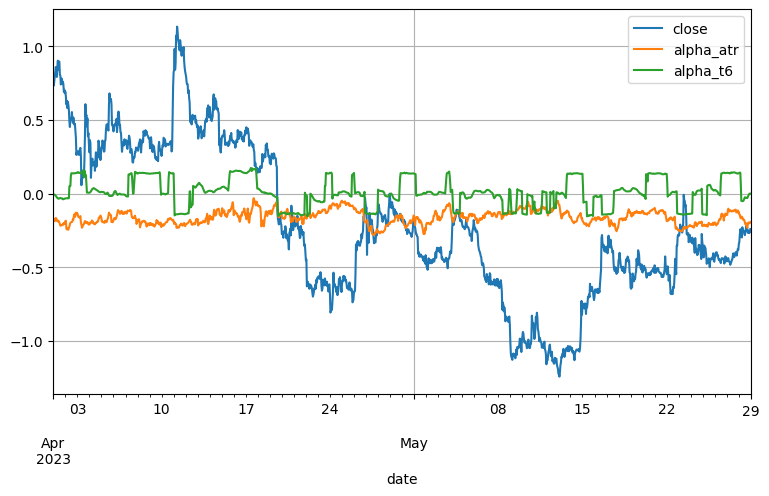

In [106]:
tmp = universe.loc[(universe.index>='2023-04-01 00:00:00') 
                   & (universe.index<='2023-05-29 00:00:00') & (universe.ts_code=='CFXUSDT')]

def rescale_tmp(sr, bias = .0):
    return sr/20 + bias
#tmp['alpha_wr'] = tmp['alpha_wr']/2000 + 1
tmp['alpha_macd'] = tmp['alpha_macd']/20
tmp['alpha_kdj'] = tmp['alpha_kdj']/20
tmp['alpha_wt'] = tmp['alpha_wt']/20
tmp['alpha_wr'] = tmp['alpha_wr']/20
tmp['alpha_ppo'] = tmp['alpha_ppo']/20
tmp['alpha_cci'] = tmp['alpha_cci']/20
tmp['alpha_t1'] = tmp['alpha_t1']/20
tmp['alpha_t2'] = rescale_tmp(tmp['alpha_t2'])
tmp['alpha_t4'] = tmp['alpha_t4']/20
tmp['alpha_t4a'] = tmp['alpha_t4a']/20
tmp['alpha_t6'] = tmp['alpha_t6']/20
tmp['alpha_srsi'] = tmp['alpha_srsi']/20
tmp['alpha_rsi'] = tmp['alpha_rsi']/20
tmp['alpha_075'] = tmp['alpha_075']/20
tmp['alpha_019'] = tmp['alpha_019']/20
tmp['alpha_atr'] = tmp['alpha_atr'] + 2.5
tmp['alpha_supertrend1'] = tmp['alpha_supertrend1']
tmp['alpha_kama1'] = tmp['alpha_kama1']

tmp['close'] = tmp['close'].shift(-1) -4
tmp[['close', 'alpha_atr', 'alpha_t6']].plot(grid=True)

In [71]:
universe.loc[universe.index>='2023-05-01 00:00:00'].sort_values(by=['alpha_t6'])[['ts_code','alpha_t6']]

,ts_code,alpha_t6
date,,
2023-05-23 19:00:00,CFXUSDT,-1.809511
2023-05-23 20:00:00,CFXUSDT,-1.807170
2023-05-23 18:00:00,CFXUSDT,-1.804518
2023-05-23 21:00:00,CFXUSDT,-1.795695
2023-05-23 17:00:00,CFXUSDT,-1.789123
...,...,...
2023-05-13 22:00:00,CFXUSDT,0.980759
2023-05-14 00:00:00,CFXUSDT,0.982532
2023-05-13 21:00:00,CFXUSDT,0.983930


In [ ]:
universe.ts_code.unique()

2.6214656339483047 0.03374584969602844


<AxesSubplot:>

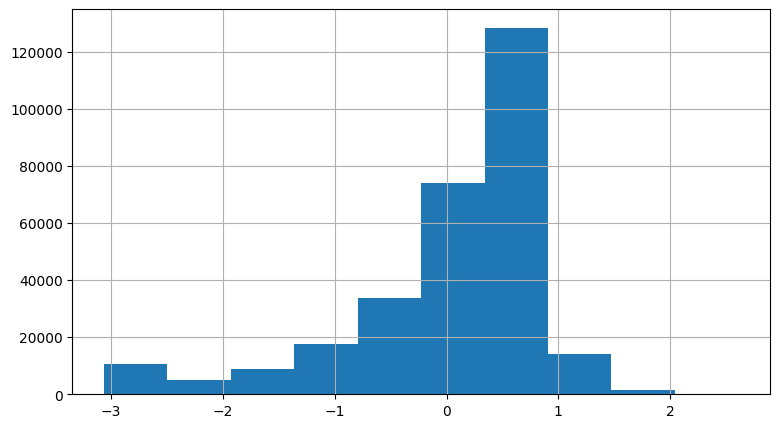

In [102]:
factor_name = 'alpha_atr'
print(universe[factor_name].std() * 3, universe[factor_name].mean())
universe[factor_name].hist()

### 因子评估

In [5]:
base_columns = [
    'ts_code', 'trade_date', 'volume', 'amount', 'trade_counts', 'buy_volume', 'buy_amount',
    'close', 'vwap', 'open', 'high', 'low',  'log-ret', 'range_14', 'wave_14',
    'range_5', 'wave_5', 'range_10', 'wave_10', 'ret_5', 'ret_10', 'buy_percent5', 'buy_percent10']

In [34]:
# t7 not need zscore
time_zscore_factors = [
    'alpha_kama1', 'alpha_atr', 'alpha_atr1', 'alpha_supertrend', 'alpha_supertrend1', 'alpha_t5', 
]

value_zscore_factors = {
    # mean and divide scale
    'alpha_wt': [0, 25],
    'alpha_cci': [0, 360],
    'alpha_cci1':[0, 200],
    'alpha_srsi':[-50, 100],
    'alpha_rsi': [-50, 100],
    'alpha_wr':[50, 100],
    'alpha_ppo':[0, 2],
    'alpha_ppo1':[0, 5],
    'alpha_macd':[0, 0.03],
    'alpha_kdj':[0,75],
    'alpha_kama':[0,0.1],
    'alpha_t1':[0,1],
    'alpha_t2':[0, 0.1],
    'alpha_t4':[0, 0.1],
    'alpha_t4a':[0, 0.1],
    'alpha_t5a':[0, 0.05],
    'alpha_t6':[0, 0.05],
    'alpha_t7':[0, 200],
    'alpha_019':[0, 0.1],
    'alpha_075':[0, 0.1],
}

factor_names = list(value_zscore_factors.keys()) + time_zscore_factors
final_columns = base_columns+factor_names

In [35]:
# def wins(x,a,b):
#     return np.where(x <= a,a, np.where(x >= b, b, x))

# def zscore_time_factors(universe, time_zscore_factors = time_zscore_factors, win=180):
#     for factor_name in tqdm(time_zscore_factors):
#         rolling_obj = universe[factor_name].rolling(len(universe.ts_code.unique()) * win)
#         universe[factor_name] = (universe[factor_name] - rolling_obj.median())/rolling_obj.std()
#         universe[factor_name] = wins(universe[factor_name], 
#                                      rolling_obj.median() - 3 * rolling_obj.std(), 
#                                      rolling_obj.median() + 3 * rolling_obj.std())
#         universe[factor_name] = universe[factor_name]/3
        
#     return universe

# def rescale_value_factors(universe, zscore_dict = value_zscore_factors):
#     for factor_name in tqdm(zscore_dict.keys()):
#         rescale_list = zscore_dict[factor_name]
#         universe[factor_name] = (universe[factor_name] - rescale_list[0])/rescale_list[1]
#     return universe
        

# universe = rescale_value_factors(universe)
# universe = zscore_time_factors(universe)

100%|█████████████████████████████████████████████| 6/6 [00:05<00:00,  1.07it/s]


In [79]:
def rescale_(data, zscore_features=factor_names):
    #data[factor_names] = data[factor_names].apply(zscore)
    # resize from -1 to 1
    for feature in zscore_features:
        data[feature] = (data[feature] - data[feature].mean())/data[feature].std()
        max_val = data[feature].median() + 3*data[feature].std()
        min_val = data[feature].median() - 3*data[feature].std()
        data[feature] = np.where(data[feature]>max_val, max_val, 
                               np.where(data[feature]<min_val, min_val, data[feature]))
        
#         data[feature] = np.where(data[feature]>0, data[feature]/data[feature].max(),
#                                  np.where(data[feature]<0, data[feature]/(-data[feature].min()), 0.))
    #data[zscore_features] = data[zscore_features]/3
    return data

def rescale_rank(data, zscore_features=factor_names):
    data[zscore_features] = data[zscore_features].rank(method='min',pct=True)
    data[zscore_features] = (data[zscore_features] - 0.5) * 2
    return data

universe = universe.replace([np.inf, -np.inf], np.nan)
universe = universe.fillna(0.)

#universe[factor_names] = universe.groupby('ts_code')[factor_names].apply(lambda x: Decaylinear(x, 4))
universe = my_groupby(universe, 'trade_date', rescale_)
#universe = my_groupby(universe, 'trade_date', rescale_rank)

100%|███████████████████████████████████████| 8708/8708 [18:07<00:00,  8.00it/s]


In [80]:
universe[final_columns].reset_index().to_feather(
    'bitcoin_data/factor_data/factors_DBM_zscore2.feather')

In [ ]:
universe = pd.read_feather('bitcoin_data/factor_data/factors_DBM_zscore.feather')
universe = universe.set_index(['date']).sort_values(by=['date', 'ts_code'])
universe.shape

In [81]:
start_time = '2023-03-01 00:00:00'
end_time = '2023-06-01 00:00:00'
# universe = universe.loc[(universe.index>=start_time) & (universe.index<=end_time)]

### 构造评估数据

In [82]:
import random
universe = universe.sort_values(by=['date','ts_code'])
all_factors = universe.copy(deep=True)
all_factors = all_factors.loc[(all_factors.index>=start_time) & (all_factors.index<=end_time)]
def return_handle(df):
    df['returns_2'] = df['close'].pct_change().shift(-1)
#     noise_list = []
#     for i in range(df.shape[0]):
#         noise = abs(random.gauss(0, 0.2))
#         if noise > 0.2:
#             noise=0.1
#         noise_list.append(noise)
#     df['returns_2'] = df['returns_2'] * (1 - np.array(noise_list)) \
#                     + np.array(noise_list)*df['close'].pct_change().shift(-1).fillna(0.)
    return df
all_factors = all_factors.groupby('ts_code').apply(return_handle)
all_factors = all_factors.replace([np.inf, -np.inf], np.nan).fillna(0.).sort_values(by=['date', 'ts_code'])
print(universe.shape, all_factors.shape)

(294307, 73) (75460, 74)


In [83]:
def keep_top_bottom(data, feature, bottom=0.45, top=0.55):
    tv = data[feature].quantile(top)
    bv = data[feature].quantile(bottom)
    data[feature] = np.where(data[feature]>tv, data[feature], 
                            np.where(data[feature]<bv, data[feature], 0))
    return data
    
    all_df = pd.DataFrame()
    for dt in tqdm(df.index.unique()):
        tmp = df.loc[df.index == dt]
        all_df = all_df.append(cal_(tmp))
    return all_df.sort_values(by=['date', 'ts_code'])


def wins(x,a,b):
    return np.where(x <= a,a, np.where(x >= b, b, x))

def get_formula(factors, Y):
    L = ["0"]
    L.extend(factors)
    return Y + " ~ " + " + ".join(L)

def factors_from_names(n, name):
    return list(filter(lambda x: name in x, n))

def estimate_factor_returns(df, name='alpha_'): 
    ## winsorize returns for fitting 
    estu = df.copy(deep=True)
    estu['returns_2'] = wins(estu['returns_2'], -0.1, 0.1)
    #all_factors = factors_from_names(list(df), name)
    results = pd.Series()
    for factor_name in factor_names:
        #estu = keep_top_bottom(estu, factor_name)
        form = get_formula([factor_name], "returns_2")
        model = ols(form, data=estu)
        result = model.fit()
        results = results.append(result.params)
    return results

In [84]:
base_field = ['ts_code', 'log-ret', 'open', 'high', 'low', 'close', 'volume', 'vwap','trade_date']
date_and_code = [ 'ts_code', 'returns_2', 'log-ret']

alpha_df = all_factors[factor_names + date_and_code].copy(deep=True)
#alpha_df = alpha_df.loc[alpha_df.index<=start_time]
calendar = alpha_df.index.unique() # int64

#alpha_df = keep_top_bottom(alpha_df, factor_names)

In [85]:
calendar

DatetimeIndex(['2023-03-01 00:00:00', '2023-03-01 01:00:00',
               '2023-03-01 02:00:00', '2023-03-01 03:00:00',
               '2023-03-01 04:00:00', '2023-03-01 05:00:00',
               '2023-03-01 06:00:00', '2023-03-01 07:00:00',
               '2023-03-01 08:00:00', '2023-03-01 09:00:00',
               ...
               '2023-05-29 11:00:00', '2023-05-29 12:00:00',
               '2023-05-29 13:00:00', '2023-05-29 14:00:00',
               '2023-05-29 15:00:00', '2023-05-29 16:00:00',
               '2023-05-29 17:00:00', '2023-05-29 18:00:00',
               '2023-05-29 19:00:00', '2023-05-29 20:00:00'],
              dtype='datetime64[ns]', name='date', length=2156, freq=None)

### 归一化回报率评估

In [86]:
for feature in tqdm(factor_names):
    alpha_df[feature + 'shift1'] = alpha_df.groupby('ts_code')[feature].shift(1)

100%|██████████████████████████████████████████| 26/26 [00:00<00:00, 138.58it/s]


In [87]:
alpha_df.loc[alpha_df['returns_2'].abs()>0.03].shape[0]/alpha_df.shape[0]

0.01704214153193745

In [88]:
q_num = 5
df = pd.DataFrame(index=alpha_df.index.unique())
for dt in tqdm(alpha_df.index.unique()):
    tmp = alpha_df.loc[alpha_df.index == dt]
    for feature in factor_names:
        #tmp['returns_2'] = wins(tmp['returns_2'], -0.06, 0.06)
        ret_sr = tmp['returns_2'] * np.sign(tmp[feature])
        # stop loss
        tmp['returns_2'] = np.where(ret_sr<-0.03, -0.035, tmp['returns_2'])
        # costs
        holding2one_now = tmp[feature]/tmp[feature].abs().sum()
        holding2one_pre = tmp[feature + 'shift1'] / tmp[feature + 'shift1'].abs().sum()
        ret_sr_pre = tmp['log-ret'] * np.sign(tmp[feature + 'shift1'])
        holding2one_pre = np.where(ret_sr_pre<-0.03, 0, holding2one_pre)
        
        tmp['holding2one'] = holding2one_now
        costs = (holding2one_now - holding2one_pre).abs().sum() * 5e-4
        liquidate_now_costs = tmp.loc[ret_sr<-0.04]['holding2one'].abs().sum() * 5e-4
        # factor return
        df.at[dt, feature] = (tmp['returns_2'] * tmp[feature]).sum()/(tmp[feature].abs().sum()) \
                                - costs - liquidate_now_costs
        
        # quartile 5 returns
#         try:
#             tmp[feature + '_q' + str(q_num)] = pd.qcut(tmp[feature], q=q_num, 
#                                                        labels=list(range(1,q_num+1)), duplicates='drop')
#         except Exception as e:
#             tmp[feature + '_q' + str(q_num)] = 2
#         for q in range(1, q_num+1):
#             # 1q 2q 3q 4q 5q
#             df.at[dt, feature + '_q' + str(q)] = tmp.loc[tmp[feature + '_q'+str(q_num)]==q]['returns_2'].sum()

100%|███████████████████████████████████████| 2156/2156 [02:59<00:00, 12.00it/s]


In [57]:
print(factor_names)

['alpha_wt', 'alpha_cci', 'alpha_cci1', 'alpha_srsi', 'alpha_rsi', 'alpha_wr', 'alpha_ppo', 'alpha_ppo1', 'alpha_macd', 'alpha_kdj', 'alpha_kama', 'alpha_t1', 'alpha_t2', 'alpha_t4', 'alpha_t4a', 'alpha_t5a', 'alpha_t6', 'alpha_t7', 'alpha_019', 'alpha_075', 'alpha_kama1', 'alpha_atr', 'alpha_atr1', 'alpha_supertrend', 'alpha_supertrend1', 'alpha_t5']


<AxesSubplot:xlabel='date'>

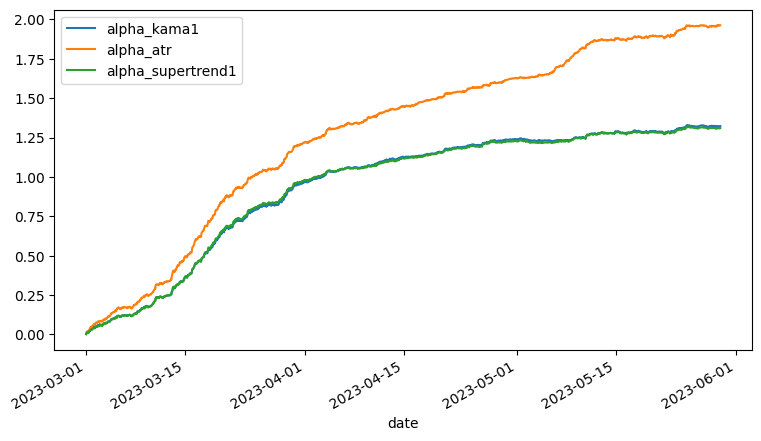

In [100]:
# 'alpha_cci', 'alpha_wt', 'alpha_macd', 'alpha_ppo', 'alpha_rsi', 'alpha_srsi1',
# 'alpha_t4', 'alpha_t2', 'alpha_078', 'alpha_075', 

display_field = [
    #'alpha_wt', 'alpha_cci', 'alpha_rsi',  'alpha_t2', 'alpha_t4a', 
    #'alpha_ppo', 'alpha_ppo1', 'alpha_macd', 'alpha_019', 'alpha_075', 'alpha_t6', 
    'alpha_kama1', 'alpha_atr', 'alpha_supertrend1'
]

df[display_field].cumsum().plot()

In [101]:
# sharp ratio
np.sqrt(2100) * df[display_field].mean()/ df[display_field].std()

alpha_kama1          12.028593
alpha_atr            14.719905
alpha_supertrend1    12.087533
dtype: float64

In [ ]:
# alpha_008    7.112507
# alpha_078    5.924321
# alpha_019    5.641981
# alpha_wt     6.093409
# alpha_cci    5.723536
# alpha_035    5.557689

feature = 'alpha_075'
q_df = pd.DataFrame(index = df.index)
for i in range(1, q_num+1):
    q_feature = feature + '_q' + str(i)
    if q_feature in df.columns:
        q_df[q_feature] = (df[q_feature]).cumsum()

q_df.plot()        

### Save  or read rescale data

In [ ]:
field = ['ts_code', 'close', 'log-ret', 'trade_date',
         'alpha_cci', 'alpha_rsi', 'alpha_wt'
        ]
universe[field].reset_index().to_feather('bitcoin_data/factor_data/facotors_DBM_backtest.feather')

In [ ]:
universe_raw = feather.read_dataframe('bitcoin_data/factor_data/factors_smooth_zscore_20221001_20230529.feather')
#universe_raw['date'] = pd.to_datetime(universe_raw['trade_date'], format='%Y-%m-%d %H:%M:%S')
universe_raw = universe_raw.set_index(['date']).sort_values(by=['date', 'ts_code'])
print(universe_raw.shape)

In [ ]:
universe_raw.columns

In [ ]:
feature = 'alpha_atr'
start_time = '2023-03-01 00:00:00'
end_time = '2023-06-01 00:00:00'
tmp = universe_raw.loc[(universe_raw.ts_code=='SHIBUSDT') & (universe_raw.index>=start_time) & (universe_raw.index<=end_time)]
#tmp[['close']] = tmp[['close']].apply(zscore)
#tmp[feature] = Decaylinear(tmp[feature],4)#.rolling(6).mean()
tmp[[feature, 'close']].plot(grid=True)